# Modeling a Beta distribution 
Normal distributions are found everywhere. Many classical statistical methods work with the assumption that the data you are working on are normally distributed. Bayesian methods are very flexible and can accomdate (almost) any distribution. For example, if we are working with proportions (i.e., values $y$ are restricted in the interval $[0, 1]$) a better choice for modelling is the Beta distribution: $y\sim\mathcal{Beta}(\alpha, \beta)$, with $\alpha, \beta\gt0$. 

The parameters $\alpha$ and $\beta$ may not be straightforward to interpret. The alternative is to combine them in order to obtain a Beta distribution in terms of mean $\mu~(0\lt\mu\lt0)$ and precision $\phi~(\phi\gt0)$:
$$\alpha = \mu\phi$$
$$\beta = (1-\mu)\phi$$

As in the previous example we will go through the steps of:
 - data collection
 - model definition
 - model sampling
 - model checking
 - inference

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
plt.style.use('seaborn-darkgrid')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st
import scipy.special as sp

SEED = 20191211

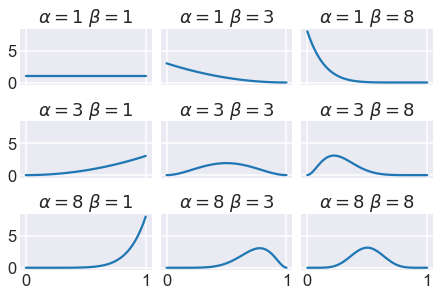

In [4]:
f, ax = plt.subplots(3, 3, sharex=True, sharey=True, constrained_layout=True)
a = [1, 3, 8]
b = [1, 3, 8]
x = np.linspace(0, 1, num=50)
for irow, row in enumerate(ax):
    for icol, col in enumerate(row):
        _a, _b = a[irow], b[icol]
        col.plot(x, st.beta.pdf(x=x, a=_a, b=_b))
        col.set_title(f'$\\alpha={_a} \\; \\beta={_b}$')

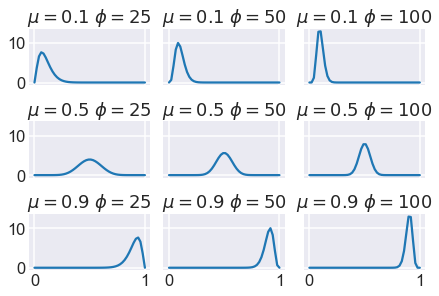

In [5]:
f, ax = plt.subplots(3, 3, sharex=True, sharey=True, constrained_layout=True)
mu = [0.1, 0.5, 0.9]
phi = [25, 50, 100]
x = np.linspace(0, 1, num=50)
for irow, row in enumerate(ax):
    for icol, col in enumerate(row):
        _mu, _phi = mu[irow], phi[icol]
        a, b = _mu*_phi, (1-_mu)*_phi
        col.plot(x, st.beta.pdf(x=x, a=a, b=b))
        col.set_title(f'$\\mu={_mu} \\; \\phi={_phi}$')

## 1) Data collection
One waiter recorded information about each tip he received over a period of a few months working in one restaurant (https://vincentarelbundock.github.io/Rdatasets/doc/reshape2/tips.html). What we want to know is how much people tip in a restaurant

In [7]:
df = pd.read_csv('./data/tips.csv', index_col=0)
df['tip_percentage'] = df['tip']/df['total_bill']
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percentage
1,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
2,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
3,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
4,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
5,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


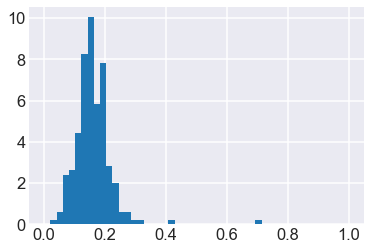

In [8]:
_ = plt.hist(df['tip_percentage'], density=True, bins=np.linspace(0, 1, num=50))

## 2) Model definition
The data we are working with are proportions, so we will use a model such as $y\sim\mathcal{Beta}(\alpha, \beta)$. As the meaning of parameters $\alpha$ and $\beta$ is a bit hard to grasp, we will reason in terms of central tendency $\mu$ and variation $\phi$

In [9]:
with pm.Model() as model:  
    # Prior on 'mu'
    mu = pm.Beta('mu', alpha=1, beta=1)
    # Prior on 'phi'
    phi = pm.HalfNormal('phi', sd=10)

    # Parametrize in terms of a, b
    alpha = pm.Deterministic('alpha', mu*phi)
    beta = pm.Deterministic('beta', (1-mu)*phi)
    
    # Likelihood
    observations = pm.Beta('observations', alpha=alpha, beta=beta, observed=df['tip_percentage'])

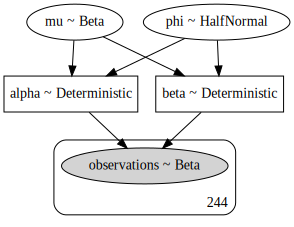

In [10]:
pm.model_to_graphviz(model)

## 3) Model sampling

In [0]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=1, random_seed=SEED)

In [0]:
_ = pm.plot_trace(trace, var_names=['mu', 'phi'])

In [0]:
pm.summary(trace, var_names=['mu', 'phi'], credible_interval=0.95)

## 4) Model checking

In [0]:
fig, ax = plt.subplots()

THIN = 100
x = np.linspace(0, 1, num=75)

ax.hist(df['tip_percentage'], density=True, bins=x)

for a, b in zip(trace['alpha'][::THIN], trace['beta'][::THIN]):
    ax.plot(x, st.beta.pdf(x=x, a=a, b=b), alpha=0.1, color='red')

## 5) Inference
Now that we have the posterior probability on the parameters we can leverage them to answer some questions on tipping behavior. For example, we may want to know what the average tip. As $\mu$ is the central tendency of the Beta distribution we can inspect what values $\mu$ can take

In [0]:
pm.plot_posterior(trace, var_names='mu', credible_interval=0.95);

Or we can ask what is the probability than on average people tip above 17%

In [0]:
pm.plot_posterior(trace, var_names='mu', credible_interval=0.95, ref_val=0.17);

Or we can ask what is the probability I will receive a tip above 17%? Now we are taking into account the uncertainty of our estimation in the parameter of the tips distribution plus the uncertainty if the tips sampling from the model (epistemic + aleatory uncertainty). We can do this by generating **new** values from our model.

> _Aleatory_ variability is the natural randomness in a process. _Epistemic_ uncertainty is the scientific uncertainty in the model of the process. It is due to limited data and knowledge. 


In [0]:
with model:
    posterior_samples = pm.sample_posterior_predictive(trace, samples=100)

posterior_samples['observations'].shape

In [0]:
(posterior_samples['observations'] > 0.18).mean()

In [0]:
# Should I switch my shifts from lunch to dinner?
for time in ['Lunch', 'Dinner']:
    plt.hist(df['tip_percentage'][df['time']==time], bins=x, density=True, alpha=0.4, label=time)
_ = plt.legend()

In [0]:
# compare the two distributions
with pm.Model() as model:  
    mu = pm.Beta('mu', alpha=1, beta=1, shape=2)
    mu_diff = pm.Deterministic('mu_diff', mu[1]-mu[0]) # lunch - dinner
    phi = pm.HalfNormal('phi', sd=10, shape=2) # one precision for condition
    phi_diff = pm.Deterministic('phi_diff', phi[1]-phi[0]) # lunch - dinner
    
    alpha = pm.Deterministic('alpha', mu*phi)
    beta = pm.Deterministic('beta', (1-mu)*phi)

    # Likelihood
    observations = pm.Beta('observations', alpha=alpha[(df['time']=='Lunch').astype(int)], beta=beta[(df['time']=='Lunch').astype(int)], observed=df['tip_percentage'])

In [0]:
model.check_test_point()

In [0]:
pm.model_to_graphviz(model)

In [0]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=1, random_seed=SEED)

In [0]:
_ = pm.plot_trace(trace, var_names=['mu', 'mu_diff', 'phi', 'phi_diff'])

In [0]:
pm.plot_posterior(trace, var_names='mu_diff', credible_interval=0.95, ref_val=0.0)

In [0]:
pm.plot_posterior(trace, var_names='phi_diff', credible_interval=0.95, ref_val=0.0)

In [0]:
with model:
    posterior_samples = pm.sample_posterior_predictive(trace, samples=100)

posterior_samples['observations'].shape

In [0]:
tips_lunch = posterior_samples['likelihood'][:, df['time']=='Lunch']
tips_dinner = posterior_samples['likelihood'][:, df['time']=='Dinner']

In [0]:
tips_lunch.reshape(-1) - tips_dinner.reshape(-1)

In [0]:
((tips_lunch.reshape(-1) - tips_dinner.reshape(-1)[:, None])>0).mean()

In [0]:
(tips_lunch[:, :50] - tips_dinner[:, :50]).mean()

In [0]:
# another way to look at this problem is to set up the model as a linear regression
for time in ['Lunch', 'Dinner']:
    plt.scatter(df['time'][df['time']==time], df['tip_percentage'][df['time']==time], alpha=0.5)

In [0]:
levels = ['Lunch', 'Dinner']
X = patsy.dmatrix('1 + C(time, levels=levels)', data=df)
X.shape

In [0]:
X

In [0]:
with pm.Model() as model:
    beta_mu_intercept = pm.Normal('beta_mu_intercept', mu=0, sigma=10)
    beta_mu_slope = pm.Normal('beta_mu_slope', mu=0, sigma=10)
    beta_mu = tt.stack(beta_mu_intercept, beta_mu_slope)
    
    mu = pm.math.invlogit(tt.dot(np.asarray(X), beta_mu))

    phi = pm.HalfNormal('phi', sd=10)

    # Parametrize in terms of a, b
    alpha = pm.Deterministic('alpha', mu*phi)
    beta = pm.Deterministic('beta', (1-mu)*phi)
    
    # Likelihood
    likelihood = pm.Beta('likelihood', alpha=alpha, beta=beta, observed=df['tip_percentage'])

In [0]:
model.check_test_point()

In [0]:
pm.model_to_graphviz(model)

In [0]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=1, random_seed=SEED)

In [0]:
_ = pm.plot_trace(trace, var_names=['beta_mu_intercept', 'beta_mu_slope'])

In [0]:
for time in ['Lunch', 'Dinner']:
    plt.scatter(df['time'][df['time']==time], df['tip_percentage'][df['time']==time], alpha=0.5)

for b0, b1 in zip(trace['beta_mu_intercept'][::THIN], trace['beta_mu_slope'][::THIN]):
    plt.plot([sp.expit(b0), sp.expit(b0 + b1)], color='red', alpha=0.3)

In [0]:
for b0, b1 in zip(trace['beta_mu_intercept'][::THIN], trace['beta_mu_slope'][::THIN]):
    plt.plot([sp.expit(b0), sp.expit(b0 + b1)], color='red', alpha=0.4)

In [0]:
trace['beta_mu_slope'].mean()